
## Predictive Modelling of Revenues of Modern American Movies 
#### by Stephen Gou
#### Oct 28, 2018
#### Student Number: 1000382908

### Introduction

A movie's box office is the most common metric to gauge its success. A good prediction of the revenue of a movie can guide production companies for building successful movies, and inform investors to pick out the most profitable movies. This project builds a model that predicts a movie's total revenue, given certain traits and facts about the movie. Only movies produced in the United States from 1990 to 2016 are considered, because the entertainment industry and economy changes over time. Movies produced after 2016 are not considered, because have not reached their full total revenue potential. Only movies produced in the U.S are considered, because the market characteristics vary over countries and the modelling of this aspect is beyond the scope of this project.
     
To build an effective predictive model and gain insight, the project first explores and analyzes the major factors that affect a movie's revenue. And then, a model that best suits the case will be selected and trained. Its performance will be analyzed and compared to an alternative model. Last but not least, the model's limitations and potential improvements will be discussed.
    
### Data Collection
This project makes use of several sources to collect data for analysis and training. Various types of data are collected that includes movie's revenue, budget, meta-data, cast, crews, rankings of actors and actresses and so on. The detail of all the datasets used is listed below.

1) TMDB 5000 Movies dataset. This is the main dataset which provides budget, revenue, runtime, genre, release-date and production country data. Source: https://www.kaggle.com/tmdb/tmdb-movie-metadata

2) New York Times Review dataset. This dataset includes data like whether a movie was picked by NYT critics, and review summaries. Source: NYT API

3) TMDB 5000 Crew dataset. This dataset has detailed cast and crew information, ranging from actor to writer, for each movie. Source: https://www.kaggle.com/tmdb/tmdb-movie-metadata

4) Top Actors/Actresses Rank. This the list of a Top 1000 Actors/Actresses Ranking released by IMDb. Source: IMDb

5) Top directors Rank. This the list of a Directors Ranking released by IMDb. Source: IMDb

6) Annual CPI. This dataset lists the annual average CPI for U.S. Source: UsInflationCalculator.com

### Data Cleaning

     
### Questions
1. Is there a statistically significant difference between the mean revenues of NY critic picks and non-picks movies?
2. Do reviews of NY critic picks display a different set of sentiments than that of non-picks?
3. What are the major characteristics of a modern American movie that affect its deomestic lifetime revenue? Modern is defined here as after 1990.

### Data Collection
- OMDb API provies a good baseline meta data about movies including release date, runtime, genre, director, writer, actors, production companies, and opening box office. However, several data of interests are missing, e.g. life-time revenue (it only provides opening box office) and budget.

- To supplement OMDb, I found The Movie Dataset on Kaggle:
    https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv
    This data was collected from TMDB. It contains revenue, budget, multiple genre tags, and keywords data.

- NY movie reviews can be accessed through its API.

- Text Blob for sentiment analysis https://textblob.readthedocs.io/en/dev/quickstart.html

### EDA
1. Plot the distribution of revenues of critic-picks vs non-picks.
    
2. Generate frequencies of words with different sentiments.

3. Feature selection and transformation for analyzing movie revenues factors
 - Pick out relevant features in the data for predicting the revenues through intuition, e.g. genre, director, keywords and actors.

 - Examine the validity of important data like revenue. For example, are these revenue figures inflation adjusted? Are they domestic and lifetime revenues? Validate some revenues with other data source like Box Office Mojo.

 - Think about how to represent and transform certain features to be ready for modelling: For instance, actors. One way to use it meaningfully is to pull external references and assign a "popularity score" to each actor.
    
 - Keywords is another example that we have to explore its range and values and figure out how to incoporate it into our model. How many unique ones are in total and how many keywords are associated with each movie? "The Dark Knight Rises" has 21 keywords associated with it, including "dc comics", "terrorist", "gotham city", "catwoman"and etc. Some words like "dc comics" might offer very good predictive value since it's associated with many movies, while others like "gotham city" and "catman" might be too specific. Here we might need to plot a histogram of frequencies of all popular keywords.

### Analysis
**1. Is there a statistically significant difference between the mean revenues of NY critic picks and non-picks movies?**
    
    Conduct a t-test on the mean revenue of critic-picks and determine if there's statistically significant difference.


**2. Do reviews of NY critic picks display a different set of sentiments than that of non-picks?**
    
    Compare the top most-frequent key words to picks vs non-picks.
    
    
**3. What are the major characteristics of a modern American movie that affect its deomestic lifetime revenue?**
- Construct a linear regression model that fits a movie's features to its revenue. Categorical features like genre tags, and key words will be one hot encoded. Reason about possible interaction terms and include them in the model. 
- Examine coefficients and their corresponding p-values to identify the most influential features that drive revenue.
- Finally, test for likely confounders. For instance, genre might affect a movie's revenue and the type of directors at the same time.
- Try random forest of regression trees and compare performance

## Introduction
## Data Collection
## Data Wrangling,Methods
## EDA
## Analysis and Modelling
## Results
## Conclusion

#### Code for importing, basic trimming and observation of data from TMDB and OMDB.

In [27]:
import json
import requests
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
    
github_raw_root = 'https://raw.githubusercontent.com/gouzhen1/Moives-Data-Analysis/master/'
#NY Reviews Dataset
ny_df = pd.read_csv(github_raw_root + 'NY_movie_reviews.csv')
ny_df.rename(columns={'display_title':'title'},inplace=True)
ny_df = ny_df[['title','mpaa_rating','critics_pick']]

#Wrangle actors and director
#TMDB Credits Dataset (for cast and director)
tmdb_credits_df = pd.read_csv(github_raw_root + 'tmdb_5000_credits.csv')
actors_rank = pd.read_csv(github_raw_root + 'Top_actors_rank.csv')['Name'].tolist()
directors_rank = pd.read_csv(github_raw_root +'All_time_director_rank.csv')['Name'].tolist()
total_actors = len(actors_rank)
total_directors = len(directors_rank)
        
def transform_cast(df):
    cast_json = df['cast']
    parsed_cast = json.loads(cast_json)
    score = 0.
    count = 0 
    for cast in parsed_cast:
        actor = cast['name']
        if actor in actors_rank:
            #discounted for later casts
            score += (0.8 ** count) * (1. - (actors_rank.index(actor)/total_actors))
        count += 1
    return score
tmdb_credits_df['cast_score'] = tmdb_credits_df.apply(transform_cast, axis = 1)

def transform_crew(df):
    crew_json = df['crew']
    parsed_crew = json.loads(crew_json)
    score = 0.
    for crew in parsed_crew:
        if crew['department'] == 'Directing' and crew['job'] == 'Director':
            director = crew['name']
            if director in directors_rank:
                score += (1. - (directors_rank.index(director)/total_directors))
            break
    return score

tmdb_credits_df['director_score'] = tmdb_credits_df.apply(transform_crew, axis = 1)
tmdb_credits_df = tmdb_credits_df[['title','cast_score','director_score']]

#TMDB Main Dataset
main_df = pd.read_csv(github_raw_root + 'tmdb_5000_movies.csv')
main_df['release_date'] = pd.to_datetime(main_df['release_date'])
main_df.drop(main_df[main_df['release_date'].dt.year < 1990].index, inplace=True)
main_df.drop(main_df[main_df['release_date'].dt.year > 2016].index, inplace=True)
main_df = main_df[main_df['revenue'] > 0]
main_df = main_df.merge(ny_df,how='left')
    
#process and filter countries
def process_country(df):
    country_json = df['production_countries']
    parsed_country = json.loads(country_json)
    if len(parsed_country) > 0:
        return parsed_country[0]['name']
    else:
        return None
main_df['production_countries'] = main_df.apply(process_country, axis = 1)
main_df = main_df[main_df['production_countries'] =='United States of America']
main_df.drop(columns='production_countries',inplace=True)

#wrangle genre
genre_dict = {}
def transform_genre(df):
    genre_json = df['genres']
    parsed_genre = json.loads(genre_json)
    result = []
    for genre in parsed_genre:
        genre_name = genre['name']
        result.append(genre_name)
        if genre_name not in genre_dict:
            genre_dict[genre_name] = 1
        else:
            genre_dict[genre_name] += 1
    
    return result
main_df['genres'] = main_df.apply(transform_genre, axis = 1)
#drop very low rare genres
del genre_dict['Foreign']
for genre in genre_dict:
    main_df['is_' + genre] = main_df['genres'].transform(lambda x: int(genre in x))
main_df.drop(columns=['genres'],inplace=True)

#map mpaa rating
rating_df = pd.get_dummies(main_df['mpaa_rating'],prefix='rating')
main_df = main_df.merge(rating_df,left_index=True,right_index=True)
main_df.drop(columns=['mpaa_rating'],inplace=True)

#adjust revenue and budget for inflation
cpi_df = pd.read_csv(github_raw_root + 'Annual_CPI.csv')
cpi_df = cpi_df.set_index('DATE')
cpi_dict = cpi_df.to_dict()['CPIAUCSL']
def get_cpi_adjusted_revenue(df):
    year = df['release_date'].year
    revenue = df['revenue']
    return cpi_dict['2017-01-01']/cpi_dict['{}-01-01'.format(year)] * revenue

def get_cpi_adjusted_budget(df):
    year = df['release_date'].year
    budeget = df['budget']
    return cpi_dict['2017-01-01']/cpi_dict['{}-01-01'.format(year)] * budeget

main_df['revenue'] = main_df.apply(get_cpi_adjusted_revenue,axis=1)
main_df['budget'] = main_df.apply(get_cpi_adjusted_budget,axis=1)
main_df = main_df.drop(columns = ['release_date','original_language','popularity','homepage','overview','spoken_languages','tagline','original_title','vote_average','vote_count','id','status','production_companies','keywords'])


In [28]:

print(main_df.shape)
main_df = main_df.merge(tmdb_credits_df,how='left')
main_df.columns = map(str.lower, main_df.columns)
main_df.to_csv('wrangled_dataset.csv')
main_df.head()


(2033, 29)


,budget,revenue,runtime,title,critics_pick,is_action,is_adventure,is_fantasy,is_science fiction,is_crime,...,is_music,is_documentary,rating_g,rating_nc-17,rating_not rated,rating_pg,rating_pg-13,rating_r,cast_score,director_score
0,2.707715e+08,3.185239e+09,162.0,Avatar,1.0,1,1,1,1,0,...,0,0,0,0,0,0,1,0,1.141077,0.836364
1,3.546846e+08,1.136173e+09,169.0,Pirates of the Caribbean: At World's End,0.0,1,1,1,0,0,...,0,0,0,0,0,0,1,0,1.943331,0.400000
2,2.669361e+08,1.158438e+09,165.0,The Dark Knight Rises,1.0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,3.147587,0.709091
3,2.776135e+08,3.033879e+08,132.0,John Carter,0.0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,1.339893,0.000000
4,3.050287e+08,1.053261e+09,139.0,Spider-Man 3,0.0,1,1,1,0,0,...,0,0,0,0,0,0,1,0,1.381308,0.490909


## EDA

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns; 
main_df.describe()

,budget,revenue,runtime,critics_pick,is_action,is_adventure,is_fantasy,is_science fiction,is_crime,is_drama,...,is_music,is_documentary,rating_g,rating_nc-17,rating_not rated,rating_pg,rating_pg-13,rating_r,cast_score,director_score
count,2.035000e+03,2.035000e+03,2035.000000,1578.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,...,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000
mean,5.440573e+07,1.627341e+08,108.094840,0.178074,0.258968,0.186241,0.099754,0.120885,0.158722,0.441769,...,0.032924,0.014742,0.019656,0.000983,0.004423,0.108600,0.296806,0.320393,1.083142,0.072986
std,5.352606e+07,2.387306e+08,18.560045,0.382696,0.438176,0.389397,0.299746,0.326073,0.365507,0.496720,...,0.178481,0.120548,0.138849,0.031342,0.066372,0.311213,0.456963,0.466742,0.770948,0.209531
min,0.000000e+00,1.471571e+01,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.644653e+07,2.516484e+07,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.407677,0.000000
50%,3.763221e+07,7.845809e+07,105.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.056600,0.000000
75%,7.770668e+07,1.983313e+08,118.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.636858,0.000000
max,4.141547e+08,3.185239e+09,254.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.307431,1.000000


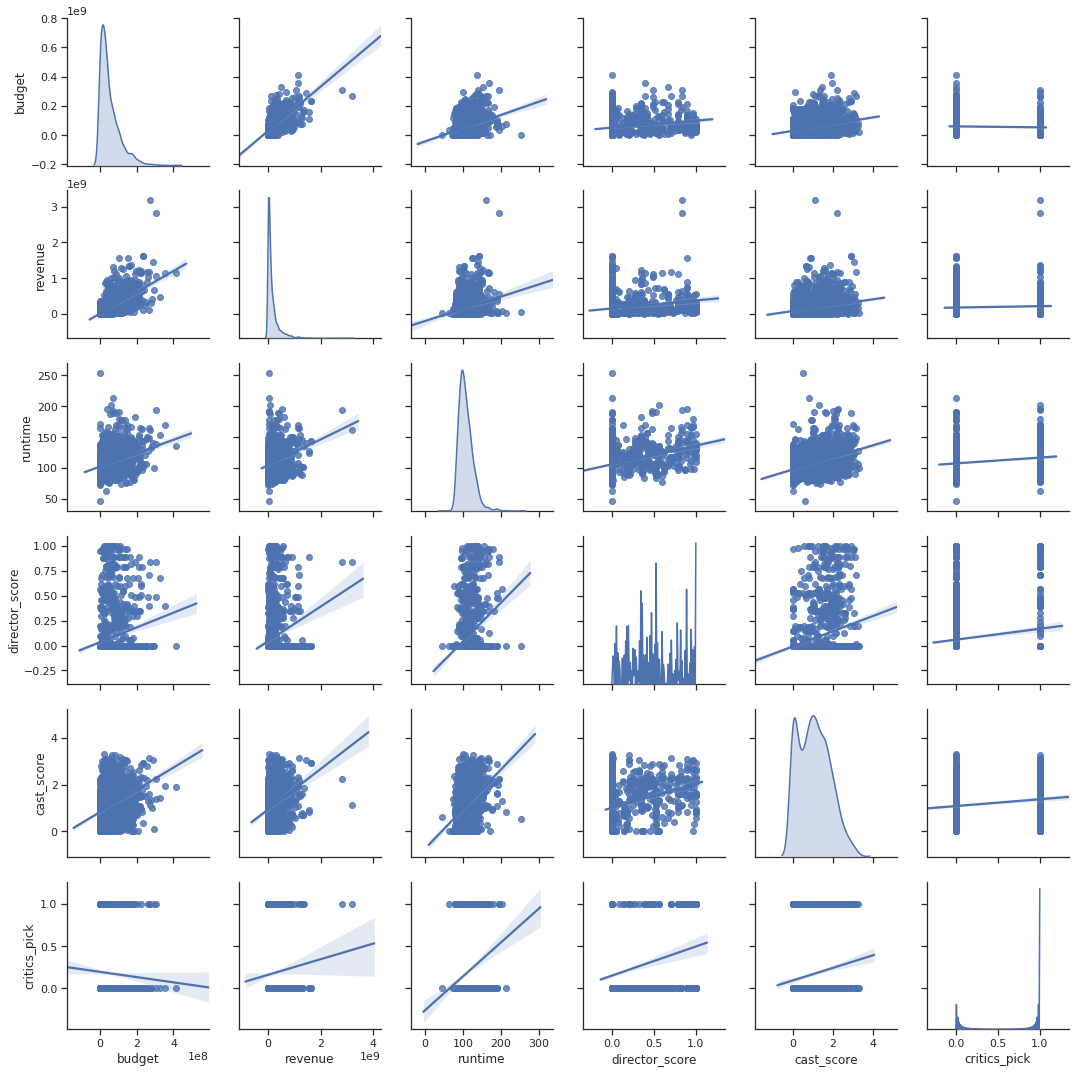

In [19]:
sns.set(style="ticks", color_codes=True)
#plt.scatter(main_df['budget'],main_df['revenue'])
sns.pairplot(main_df[['budget','revenue','runtime','director_score','cast_score','critics_pick']],kind='reg',diag_kind='kde')

### Analysis and Modelling

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = smf.ols('revenue ~ budget + cast_score', data=main_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     841.5
Date:                Sun, 28 Oct 2018   Prob (F-statistic):          6.02e-267
Time:                        16:39:04   Log-Likelihood:                -41530.
No. Observations:                2035   AIC:                         8.307e+04
Df Residuals:                    2032   BIC:                         8.308e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.292e+07   7.13e+06     -1.811      0.0

## Helper functions
Functions for retrieving data from NYT movies API and OMDB API. Results are saved in csv files.

In [22]:
#Codes for scraping, dont run. saved to csv file.
NYT_API_KEY = '53223e11b006467490bde835d45b0c74'

all_ny_df = []
for offset in range(0,8000,20):
    url = 'http://api.nytimes.com/svc/movies/v2/reviews/search.json?opening-date=1990-01-01;2016-12-31&offset={0}&api-key=ae71411b586e4f9c82502e7e782b122d'.format(offset)
    ny_json = pd.read_json(url, orient = 'records')
    ny_df = json_normalize(ny_json['results'])
    if ny_df.empty:
        break
    all_ny_df.append(ny_df)

ny_df = pd.concat(all_ny_df)
print(ny_df.tail())
ny_df.to_csv('NY Movie Reviews.csv')


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


             byline  critics_pick         date_updated  \
14  Bosley Crowther             0  2017-11-02 04:17:49   
15  BOSLEY CROWTHER             0  2017-11-02 04:17:54   
16  Thomas M. Pryor             0  2017-11-02 04:17:59   
17  FRANK S. NUGENT             0  2017-11-02 04:18:02   
18           H.T.S.             0  2017-11-02 04:17:59   

                                      display_title  \
14  Franz Kafka's &quot;It's a Wonderful Life&quot;   
15                             Hunting for Pheasant   
16                                       Svetly Put   
17                              The Kid from Kokomo   
18                                Der KÃ¶nigswalzer   

                         headline  \
14  IT'S A WONDERFUL LIFE (MOVIE)   
15            Hymn of the Nations   
16                          Tanya   
17           Kid From Kokomo, The   
18               Royal Waltz, The   

                             link.suggested_link_text link.type  \
14  Read the New York Times Re

title = 't=' + nytdata['display_title'][1].replace(' ', '+')
req = 'http://www.omdbapi.com/?apikey='+ OMDB_API_KEY + '&'+ title
print(pd.read_json(req))

In [ ]:
OMDB_API_KEY = 'd42886f4'

def fetch_omdb(title):
    title = 't=' + title.replace(' ', '+')
    print (title)
    req = 'http://www.omdbapi.com/?apikey='+ OMDB_API_KEY + '&'+ title
    omdb_df = pd.read_json(req)
    return omdb_df

count = 0
omdb_df_list = []
for title in tmdb_df['title'].tolist():
    count += 1
    omdb_df_list.append(fetch_omdb(title))
    if count > 5:
        break
        
complete = pd.concat(omdb_df_list,axis=0)
complete.to_csv('omdb_data.csv')
